In [4]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import cartopy.crs as ccrs
from sklearn.cluster import DBSCAN
import numpy as np

# Connect to the SQLite databases
db = sqlite3.connect('data/crash_reporting.db')
db2 = sqlite3.connect('data/vehicle_collision.db')

# Load data from SQLite databases
df1 = pd.read_sql("SELECT * FROM crash_reporting", db)
df2 = pd.read_sql("SELECT * FROM vehicle_collision", db2)

In [5]:
df1.head(5)

,crash_date/time,route_type,road_name,collision_type,weather,surface_condition,light,traffic_control,driver_at_fault,speed_limit,driverless_vehicle,vehicle_model,latitude,longitude
0,12/06/2023 06:42:00 PM,Maryland (State),CONNECTICUT AVE,STRAIGHT MOVEMENT ANGLE,CLEAR,DRY,DARK LIGHTS ON,STOP SIGN,No,35,No,A3,39.025170,-77.076333
1,08/28/2023 11:09:00 AM,Maryland (State),NORBECK RD,SAME DIR REAR END,CLOUDY,DRY,DAYLIGHT,NO CONTROLS,No,30,No,ML360,39.116462,-77.050530
2,07/27/2023 12:30:00 PM,County,GREENTREE RD,STRAIGHT MOVEMENT ANGLE,CLEAR,DRY,DAYLIGHT,NO CONTROLS,No,30,No,PILOT,39.000144,-77.109881
3,11/10/2023 08:24:00 PM,Maryland (State),GEORGIA AVE,SAME DIR REAR END,CLEAR,DRY,DARK LIGHTS ON,TRAFFIC SIGNAL,No,35,No,CAMRY,39.072460,-77.064860
4,10/16/2023 07:33:00 PM,Maryland (State),GEORGIA AVE,HEAD ON LEFT TURN,CLEAR,DRY,DARK LIGHTS ON,NO CONTROLS,Yes,35,No,ACCORD,39.054407,-77.050488


In [6]:
df2.head(5)

,crash_date,crash_time,borough,latitude,longitude,on_street_name,number_of_persons_injured,number_of_persons_killed,vehicle_type_code_1
0,12/14/2021,14:58,MANHATTAN,40.751440,-73.973970,3 AVENUE,0.0,0.0,Sedan
1,12/14/2021,16:50,QUEENS,40.675884,-73.755770,SPRINGFIELD BOULEVARD,0.0,0.0,Sedan
2,12/14/2021,23:10,QUEENS,40.666840,-73.789410,NORTH CONDUIT AVENUE,2.0,0.0,Sedan
3,12/11/2021,19:43,BRONX,40.872620,-73.904686,WEST KINGSBRIDGE ROAD,1.0,0.0,Station Wagon/Sport Utility Vehicle
4,12/13/2021,6:30,QUEENS,40.753730,-73.885050,82 STREET,0.0,0.0,Sedan


In [7]:
df1.columns

Index(['crash_date/time', 'route_type', 'road_name', 'collision_type',
       'weather', 'surface_condition', 'light', 'traffic_control',
       'driver_at_fault', 'speed_limit', 'driverless_vehicle', 'vehicle_model',
       'latitude', 'longitude'],
      dtype='object')

In [8]:
df2.columns

Index(['crash_date', 'crash_time', 'borough', 'latitude', 'longitude',
       'on_street_name', 'number_of_persons_injured',
       'number_of_persons_killed', 'vehicle_type_code_1'],
      dtype='object')

In [9]:
# Display basic information about the data
df1_info = df1.describe()
df2_info = df2.describe()
print(df1_info)
print(df2_info)

         speed_limit       latitude      longitude
count  136706.000000  136706.000000  136706.000000
mean       34.825977      39.083041     -77.112418
std         8.076325       0.071858       0.096435
min         0.000000      37.720000     -79.486000
25%        30.000000      39.024200     -77.187874
50%        35.000000      39.074510     -77.105234
75%        40.000000      39.139153     -77.040970
max        75.000000      39.988369     -75.975952
           latitude     longitude  number_of_persons_injured  \
count  1.110270e+06  1.110270e+06               1.110270e+06   
mean   4.064950e+01 -7.379110e+01               3.263891e-01   
std    1.716006e+00  3.112966e+00               7.091537e-01   
min    0.000000e+00 -7.425496e+01               0.000000e+00   
25%    4.066684e+01 -7.397746e+01               0.000000e+00   
50%    4.071889e+01 -7.393077e+01               0.000000e+00   
75%    4.076543e+01 -7.387161e+01               0.000000e+00   
max    4.091247e+01  0.000000

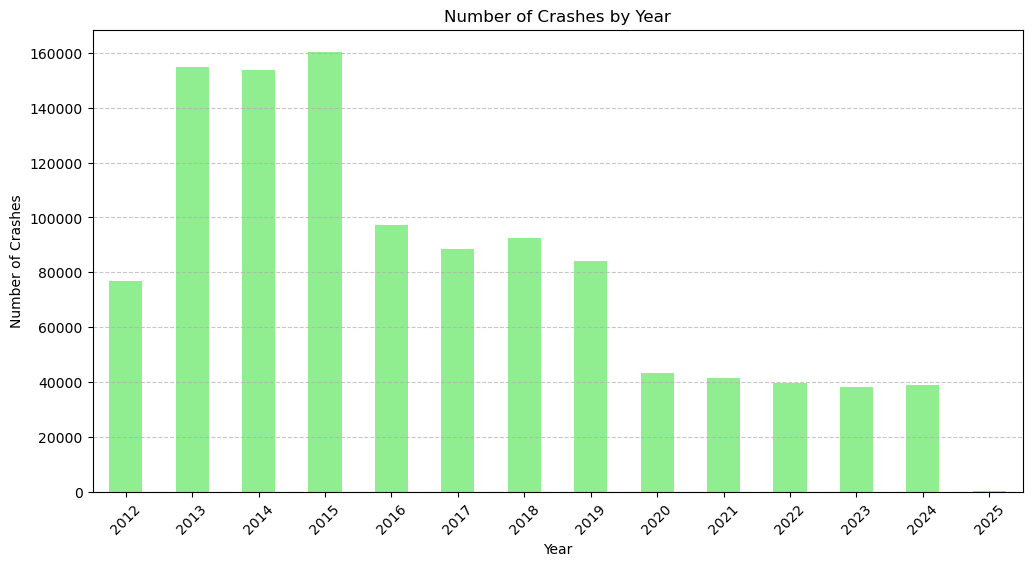

In [10]:
# Convert crash_date to datetime
df2['crash_date'] = pd.to_datetime(df2['crash_date'], errors='coerce')
df2['year'] = df2['crash_date'].dt.year
yearly_crashes = df2.groupby('year').size()

# Bar chart for crashes by year
plt.figure(figsize=(12, 6))
yearly_crashes.plot(kind='bar', color='lightgreen')
plt.title('Number of Crashes by Year')
plt.xlabel('Year')
plt.ylabel('Number of Crashes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('figure-1')
plt.show()


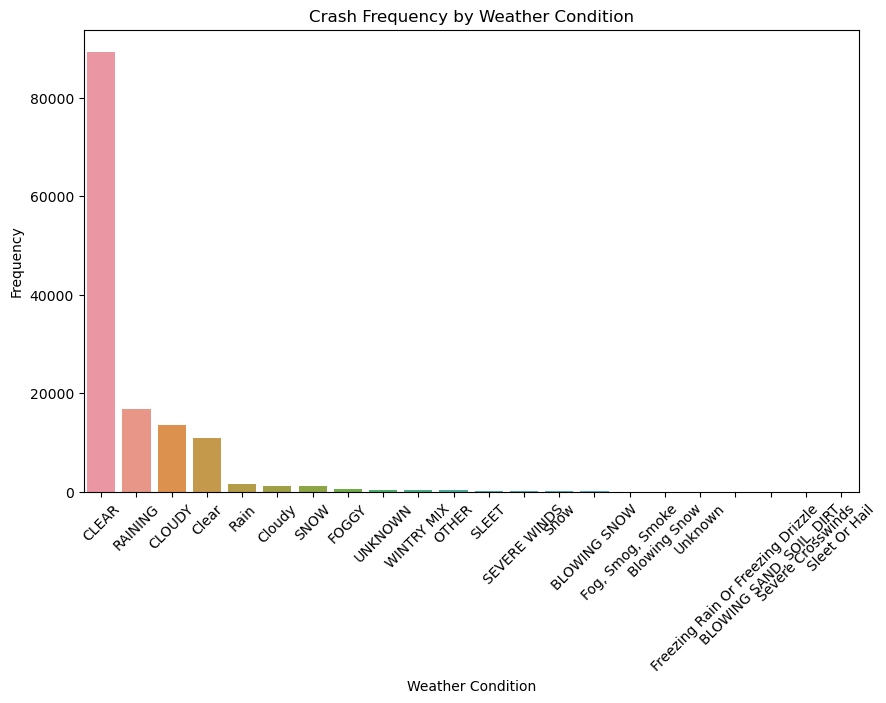

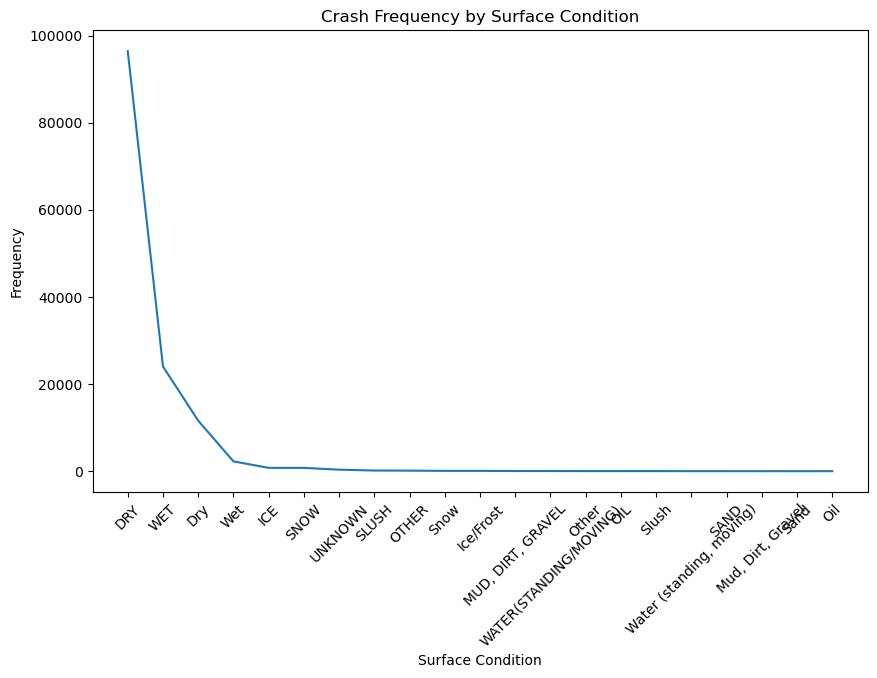

In [11]:
# Analyze weather and surface conditions in df1
weather_condition_counts = df1['weather'].value_counts()
surface_condition_counts = df1['surface_condition'].value_counts()

# Plot weather conditions
plt.figure(figsize=(10, 6))
sns.barplot(x=weather_condition_counts.index, y=weather_condition_counts.values)
plt.title('Crash Frequency by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Plot surface conditions
plt.figure(figsize=(10, 6))
sns.lineplot(x=surface_condition_counts.index, y=surface_condition_counts.values)
plt.title('Crash Frequency by Surface Condition')
plt.xlabel('Surface Condition')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.savefig('figure-2')
plt.show()


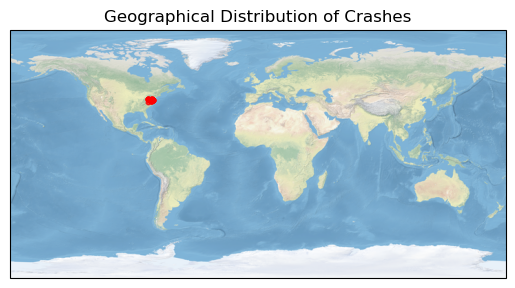

In [12]:
# Create geospatial points for crash locations
geometry = [Point(xy) for xy in zip(df1['longitude'], df1['latitude'])]
geo_df = gpd.GeoDataFrame(df1, geometry=geometry)

# Create a Cartopy map projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.stock_img()

# Plot the crashes on the map
geo_df.plot(ax=ax, markersize=10, color='red', alpha=0.5, transform=ccrs.PlateCarree())
plt.title('Geographical Distribution of Crashes')
plt.savefig('figure-3')
plt.show()

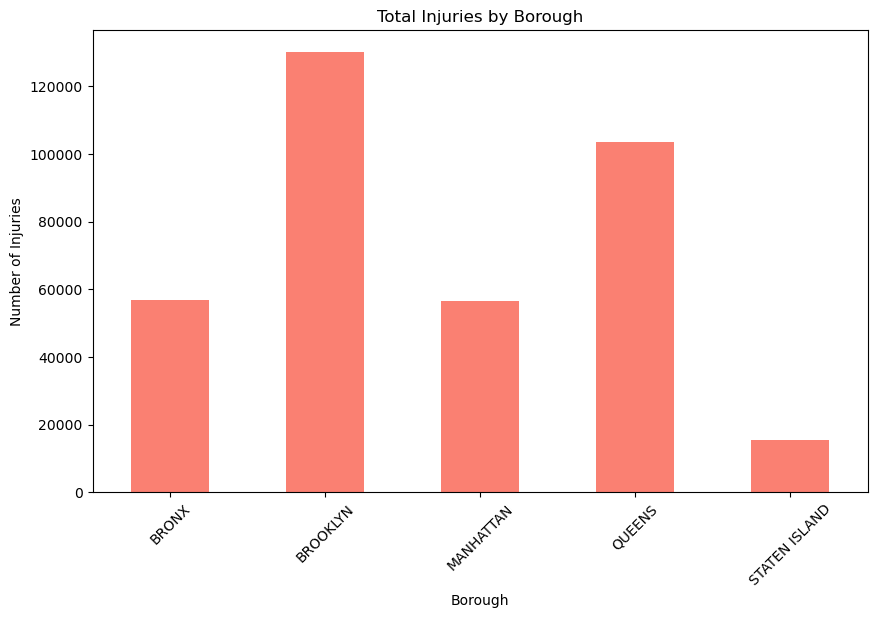

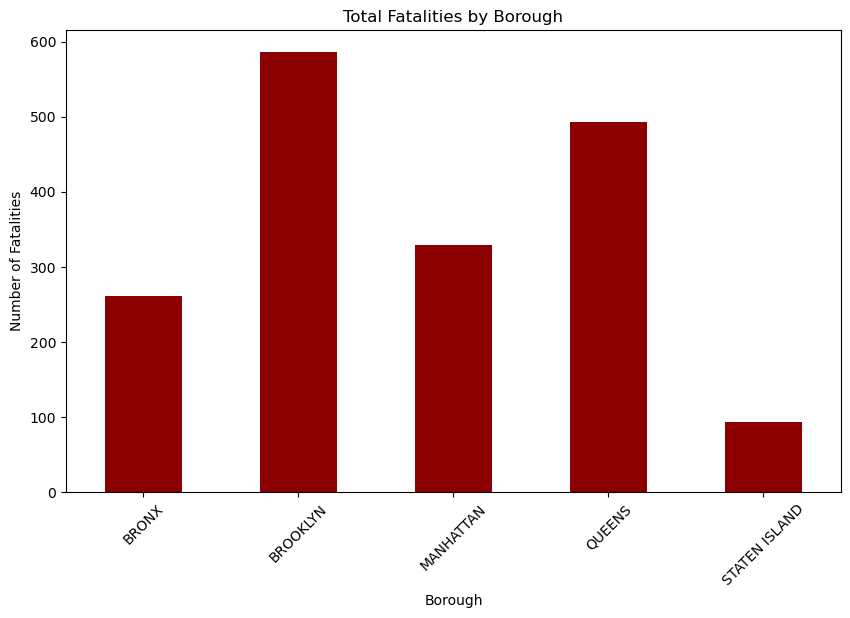

In [13]:
# Analyze the number of injuries and fatalities per borough
borough_injuries = df2.groupby('borough')['number_of_persons_injured'].sum()
borough_fatalities = df2.groupby('borough')['number_of_persons_killed'].sum()

# Plot injuries by borough
plt.figure(figsize=(10, 6))
borough_injuries.plot(kind='bar', color='salmon')
plt.title('Total Injuries by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Injuries')
plt.xticks(rotation=45)
plt.savefig('figure-4')
plt.show()

# Plot fatalities by borough
plt.figure(figsize=(10, 6))
borough_fatalities.plot(kind='bar', color='darkred')
plt.title('Total Fatalities by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Fatalities')
plt.xticks(rotation=45)
plt.savefig('figure-5')
plt.show()

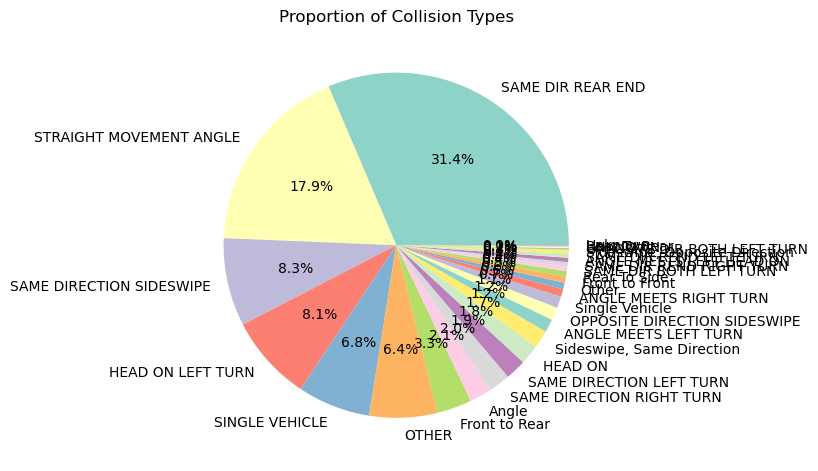

In [14]:
plt.figure(figsize=(8, 8))
df1['collision_type'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette("Set3", len(df1['collision_type'].unique())))
plt.title('Proportion of Collision Types')
plt.ylabel('')
plt.tight_layout()
plt.savefig('figure-6')
plt.show()

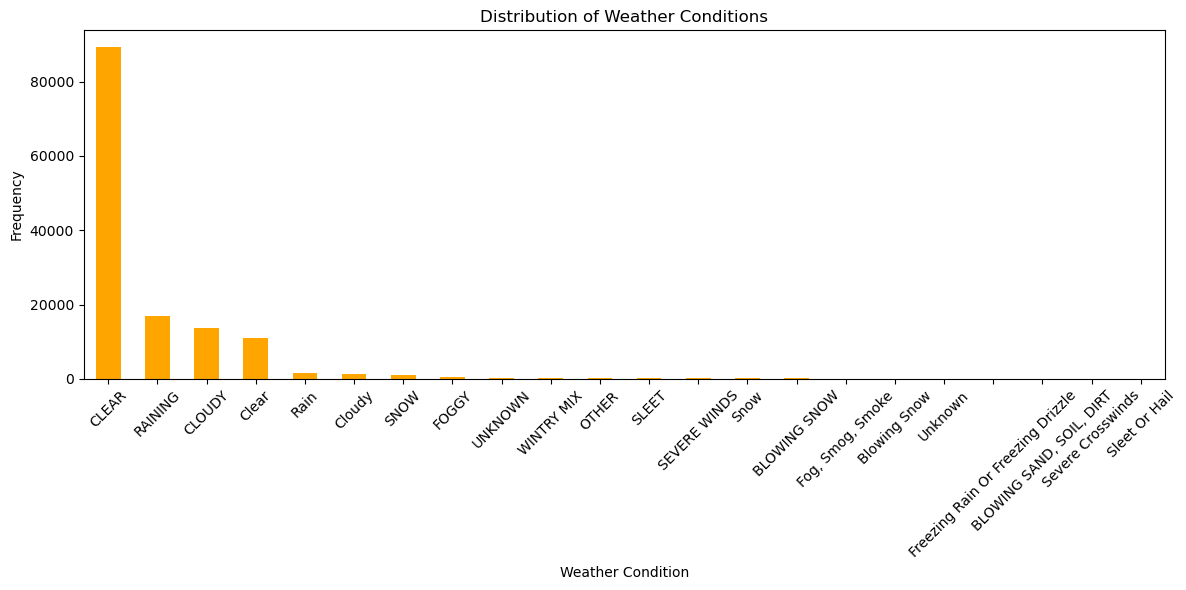

In [15]:
# Histogram: Distribution of weather conditions (df1)
plt.figure(figsize=(12, 6))
df1['weather'].value_counts().plot(kind='bar', color='orange')
plt.title('Distribution of Weather Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figure-7')
plt.show()

In [16]:
# Merge df1 and df2 based on latitude and longitude
merged_df = pd.merge(df1, df2, how='inner', on=['latitude', 'longitude'], suffixes=('_df1', '_df2'))

# Convert date columns to datetime format and extract the year
df1['year'] = pd.to_datetime(df1['crash_date/time']).dt.year
df2['year'] = pd.to_datetime(df2['crash_date']).dt.year

# Group by year
df1_yearly = df1.groupby('year').size()
df2_yearly = df2.groupby('year').size()


In [17]:
print(df1.columns)
print(df2.columns)

Index(['crash_date/time', 'route_type', 'road_name', 'collision_type',
       'weather', 'surface_condition', 'light', 'traffic_control',
       'driver_at_fault', 'speed_limit', 'driverless_vehicle', 'vehicle_model',
       'latitude', 'longitude', 'year'],
      dtype='object')
Index(['crash_date', 'crash_time', 'borough', 'latitude', 'longitude',
       'on_street_name', 'number_of_persons_injured',
       'number_of_persons_killed', 'vehicle_type_code_1', 'year'],
      dtype='object')


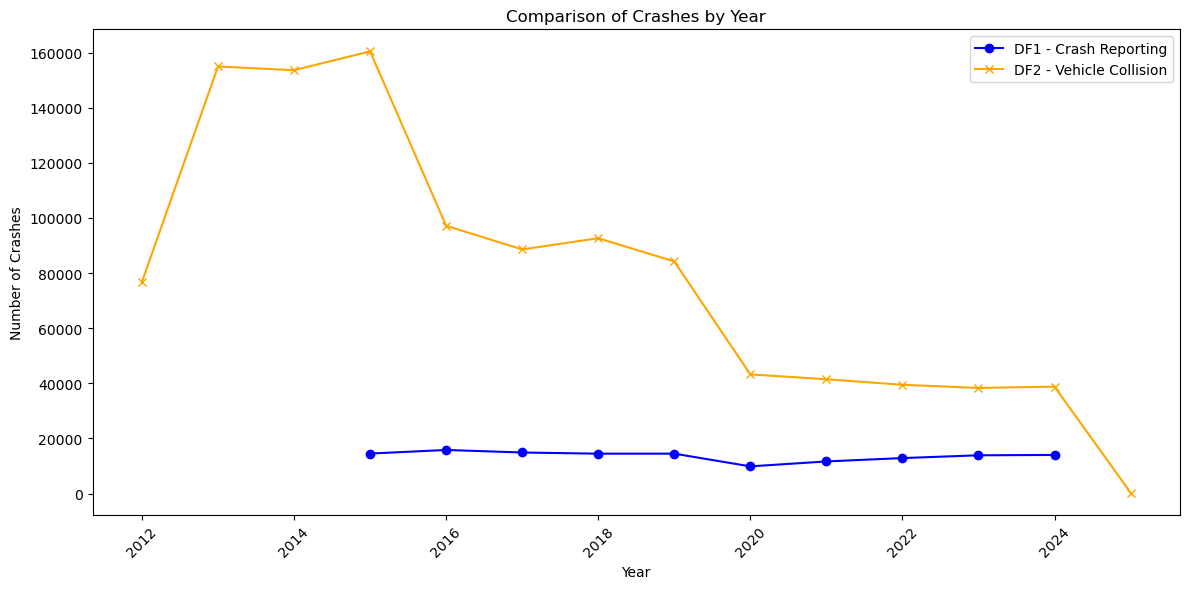

In [18]:
#(comparison)
plt.figure(figsize=(12, 6))

# Plot(Crash Reporting data)
plt.plot(df1_yearly.index, df1_yearly.values, label='DF1 - Crash Reporting', color='blue', marker='o')

# Plot (Vehicle Collision data)
plt.plot(df2_yearly.index, df2_yearly.values, label='DF2 - Vehicle Collision', color='orange', marker='x')
plt.title('Comparison of Crashes by Year')
plt.xlabel('Year')
plt.ylabel('Number of Crashes')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figure-8')
plt.show()


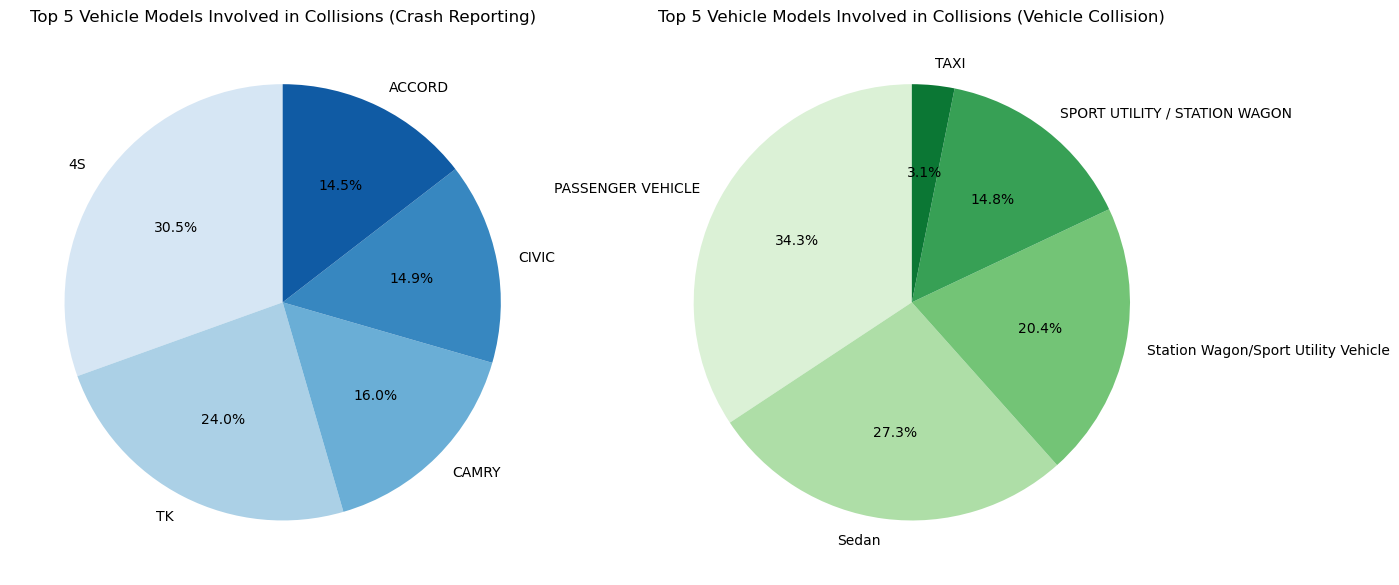

In [19]:
# Group by vehicle model for two data table, counting the occurrences
df1_vehicle_models = df1['vehicle_model'].value_counts().head(5)
df2_vehicle_models = df2['vehicle_type_code_1'].value_counts().head(5) 

# Plotting pie charts for the top 5 car models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.pie(df1_vehicle_models, labels=df1_vehicle_models.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Blues", len(df1_vehicle_models)))
ax1.set_title('Top 5 Vehicle Models Involved in Collisions (Crash Reporting)')

ax2.pie(df2_vehicle_models, labels=df2_vehicle_models.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Greens", len(df2_vehicle_models)))
ax2.set_title('Top 5 Vehicle Models Involved in Collisions (Vehicle Collision)')

plt.tight_layout()
plt.savefig('figure-9')
plt.show()


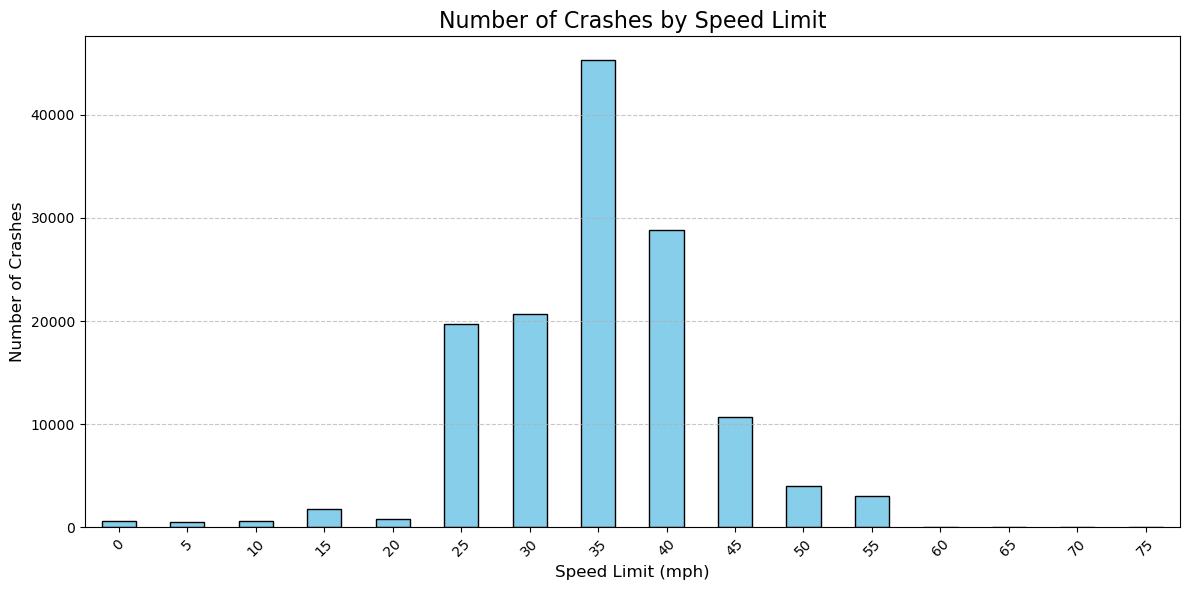

In [20]:
# Group by speed limit and calculate the number of crashes
speed_limit_analysis = df1.groupby('speed_limit').size()

# Plot the bar chart
plt.figure(figsize=(12, 6))
speed_limit_analysis.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Crashes by Speed Limit', fontsize=16)
plt.xlabel('Speed Limit (mph)', fontsize=12)
plt.ylabel('Number of Crashes', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('figure-10')
plt.show()

In [21]:
df1['driver_at_fault']

0          No
1          No
2          No
3          No
4         Yes
         ... 
136701     No
136702     No
136703    Yes
136704     No
136705    Yes
Name: driver_at_fault, Length: 136706, dtype: object

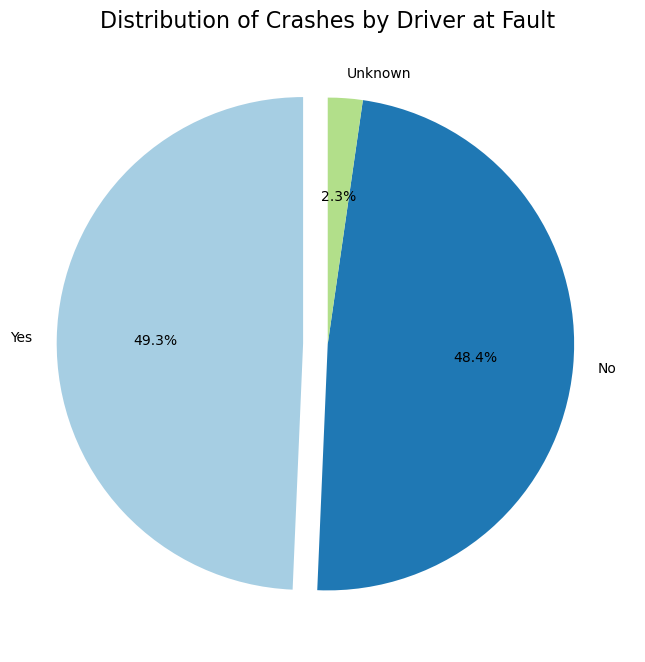

In [22]:
# Group by 'driver_at_fault' and count occurrences
driver_fault_distribution = df1['driver_at_fault'].value_counts()

# Create the explode list with 0.1 for the first value and 0 for others
explode = [0.1] + [0] * (len(driver_fault_distribution) - 1)

# Plot the pie chart
plt.figure(figsize=(8, 8))
driver_fault_distribution.plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=plt.cm.Paired.colors[:len(driver_fault_distribution)],
    startangle=90,
    explode=explode,
    labels=driver_fault_distribution.index
)
plt.title('Distribution of Crashes by Driver at Fault', fontsize=16)
plt.ylabel('')
plt.savefig('figure-11')
plt.show()


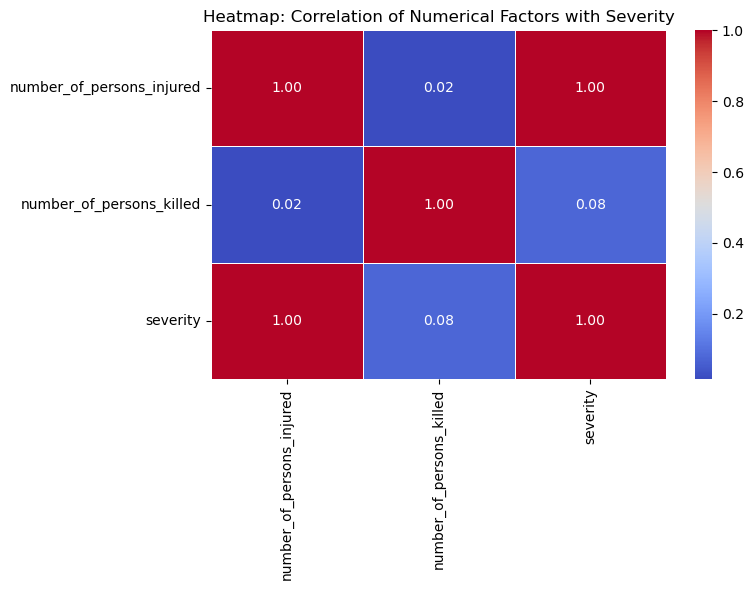

In [23]:
# Heatmap: Correlation of numerical factors with severity
# Create a new 'severity' column based on the injuries and fatalities
df2['severity'] = df2['number_of_persons_injured'] + df2['number_of_persons_killed']

# Select relevant numerical columns
numerical_columns = ['number_of_persons_injured', 'number_of_persons_killed', 'severity']

# Compute the correlation matrix
correlation_matrix = df2[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Heatmap: Correlation of Numerical Factors with Severity')
plt.tight_layout()
plt.savefig('figure-12')
plt.show()